In [1]:
import os
import string
import unicodedata
import nltk
import spacy
import gensim
import requests
import hdbscan
import numpy as np
import re
import hdbscan
import matplotlib.pyplot as plt

from wordcloud import WordCloud
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from gensim import corpora
from gensim.models import LdaModel, CoherenceModel
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures, TrigramCollocationFinder, TrigramAssocMeasures
from nltk import pos_tag
from nltk.util import ngrams
from collections import Counter, defaultdict
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer


d:\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load NLP Models
spacy_nlp = spacy.load("en_core_web_sm")
#embedding_model = SentenceTransformer("all-MiniLM-L6-v2") faster
embedding_model = SentenceTransformer("all-mpnet-base-v2") 
stop_words = set(stopwords.words("english"))

# Fetch stopwords
def fetch_stopwords_from_github(url):
    response = requests.get(url)
    return set(response.text.splitlines())

github_stopwords_url = 'https://raw.githubusercontent.com/stopwords-iso/stopwords-en/master/stopwords-en.txt'
github_stopwords = fetch_stopwords_from_github(github_stopwords_url)

stop_words = set(stopwords.words('english'))
custom_stop_words = ['like', 'yeah', 'know', 'um', 'uh', 'really', 'one', 'go', 'right', 'okay', 'well', 'said', 
                    'going', 'got', 'na', 'always', 'every', 'each', 'say', 'el', 'little', 'still', 
                    'best', 'dutch', 'nice', 'great', 'awesome', 'good', 'cool', 'love', 'amazing', 'wow',
                    'breaking news', 'report', 'coverage', 'investigation', 'interview', 'documentary', 'news', 'netherlands', 'psy', 'subtitle', 'description', 'link', 
                    'journalist', 'headline', 'reporter', 'current events', 'special report', 
                    'analysis', 'documented', 'broadcast', 'reporting', 'v', 'food', 'travel', 'react', 
                    'reacts', 'reaction', 'foreigner', 'thing', 'visit', 'dc', 'japan', 'first', 'fast', 
                    'asia', 'ang', 'indian', 'thai', 'vietnamese', 'russia', 'gon', 'canada', 'canadian', 'russian', 
                    'russia', 'guy', 'lot', 'bit', 'diba', 'ola', 'cuz', 'thai', 'thailand', 'person', 'citizen', 'foreigner', 'foreign', 'foreigners',
                    'facebook', 'filipinos', 'filipinas', 'vlog', 'vlogs', 'vlogging', 'hashtag', 'india', 'bro', 'dito', 'people', 'time', 'music', 'gonna', 'life', 
                    'lol', 'guys', 'tho', 'cute', 'hmm', 'huh', 'channel', 'subscribe', 'day6', 'mandarin', 'chinese', 'beautiful',
                    'chuckles', 'fbe', 'hit', 'laughs', 'yo', 'ka', 'word', 'living', 'boi', 'minimum', 'ya', 'successful', 'perfectly', 'yeap', 
                    'wondering', 'fantastic', 'hurry', 'german', 'age', 'country', 'subscribing', 'bluesy', 'jump', 'pretty', 'understanding', 'personalized',
                    'and', 'the', 'to', 'of', 'in', 'for', 'on', 'with', 'at', 'by', 'from', 'up', 'about', 'over', 'into', 'through', 'between', 'under', 'against', 'all',
                    'you', 'haha', 'hahaha', 'ha', 'hey', 'bye', 'hello', 'hi', 'oh', 'blah', 'easy', 'alright', 'ta', 'day', 'ooh', 'en', 'do', 'lot', 'comment', 'notification', 
                    'korean', 'jjajangmyeon', 'jajangmyeon', 'damn', 'yall', 'month', 'week', 'year', 'ohhh', 'pvf', 'dude', 'mmm', 'kagilagilalas', 'ofcourse', 'australia', 'uxo', 
                    'atleast', 'yusuf', 'bangkok', 'ot', 'anytime', 'allover', 'kala', 'nope', 'wan', 'brazil', 'smooth', 'ot', 'timeshere', 'batchof', 'yep', 'opo', 'del',
                    'gosh', 'po', 'ourself', 'wo', 'wait', 'ugh', 'nyc', 'whoa', 'nicaragua', 'yup', 'em', 'bout', 'le', 'omg', 'overwhelm', 'maam', 'nicer', 'haha', 'hahaha', 'ha', 
                    'nbcs', 'lana', 'rc', 'whatsoever', 'oxy', 'decade', 'whyd', 'unknown', 'ahhhhh', 'ohoh', 'ohto', 'ohhhh', 'bruh', 'ooe', 'ahmedabad', 'mexico', 
                    'understand', 'excuse', 'kinda', 'applause', 'oooh', 'thiswhat', 'nevermind', 'ahh', 'againthank', 'toto', 'aww', 'nah', 'bbmas', 'ay', 'op', 'huh', 'huhu',
                    'tada', 'beacuse', 'voila', 'upstairs', 'thatswhy', 'yea', 'that', 'armenia', 'or', 'not', 'funwhat', 'aka', 'armeniathat', 'woosexy', 'worth', 'laugh', 'box', 
                    'xd', 'vb', 'eff', 'ananya', 'welsh', 'latron', 'shout', 'whatwhat', 'what', 'pause', 'why', 'thats', 'byebye', 'iv', 'bye', 'ado', 'ownup', 'dom', 'jomm', 'sir', 
                    'budgie', 'nomac', 'lavocha', 'germany', 'why', 'walang', 'superduper', 'philip', 'mom', 'jre', 'giddy', 'intro', 'dupe', 'europe', 'dream', 'team', 'dislike', 'content', 
                    'yoongi', 'royale', 'ilu', 'jhope', 'day', 'jin', 'ecc', 'nyhs', 'nego', 'chavez', 'pb', 'everyones', 'epic', 'matter', 'oneonone', 'region', 'change', 'ho', 'seetoh', 
                    'atin', 'vpn', 'facetune', 'busu', 'mackie', 'clyd', 'china', 'rest', 'friend', 'woah', 'dindins', 'poster', 'vibe', 'woman', 'boss', 'woah', 'type', 'mahana', 'joke', 
                    'taller', 'insane', 'whang', 'psa', 'manatee', 'recommend', 'caesar', 'mmmhmm', 'mosul', 'dun', 'clue', 'naysayer', 'hindi', 'ko', 'pero', 'bulgaria', 'question', 'video', 
                    'yobi', 'hindu', 'expat', 'option', 'gap', 'eu', 'simo', 'kouignamann', 'bct', 'month', 'cfo', 'philippines', 'philippine', 'british', 'filipino', 'video', 
                    'http', 'korea', 'korean', 'youtube', 'google', 'united', 'america', 'american', 'kpop', '필리핀', 'bts', 'blackpink', 'twice', 'exo', 'k-pop', 
                    'seventeen', 'stray kids', 'nct', 'kdrama', 'aespa', 'taehyung', 'jimin', 'jungkook']
stop_words.update(custom_stop_words, github_stopwords)

lemmatizer = WordNetLemmatizer()

# Folder paths
transcripts_folder_path = 'standard_dataset/'
tags_folder_path = 'tags/'

# Function to load video tags only for fetched video IDs
def load_video_tags(folder_path, video_ids):
    video_tags = {}
    for video_id in video_ids:
        tag_file = os.path.join(folder_path, f"{video_id}.txt")
        if os.path.exists(tag_file):
            with open(tag_file, "r", encoding="utf-8") as file:
                tags_content = file.read().lower()
                video_tags[video_id] = tags_content.split()  # Store as list of words
        else:
            video_tags[video_id] = []  # Default to empty list if no tags
    return video_tags

video_ids = []
transcript_files = []
for file_name in os.listdir(transcripts_folder_path):
    if file_name.endswith('.txt'):
        video_id = file_name.split('_captions')[0]
        video_ids.append(video_id)
        transcript_files.append((video_id, file_name)) 

video_tags = load_video_tags(tags_folder_path, video_ids)

d:\Python\Python312\Lib\site-packages\spacy\util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.7.1) was trained with spaCy v3.7.2 and may not be 100% compatible with the current version (3.8.4). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [3]:
def is_latin_script(word):
    return all('LATIN' in unicodedata.name(char, '') or char.isdigit() for char in word)

# Function to detect both bigram and trigram collocations
def detect_collocations(tokens, min_freq=3):
    bigram_measures = BigramAssocMeasures()
    trigram_measures = TrigramAssocMeasures()

    # Find bigrams
    bigram_finder = BigramCollocationFinder.from_words(tokens)
    bigram_finder.apply_freq_filter(min_freq)
    bigrams = set(['_'.join(bigram) for bigram in bigram_finder.nbest(bigram_measures.pmi, 10)])

    # Find trigrams
    trigram_finder = TrigramCollocationFinder.from_words(tokens)
    trigram_finder.apply_freq_filter(min_freq)
    trigrams = set(['_'.join(trigram) for trigram in trigram_finder.nbest(trigram_measures.pmi, 10)])

    return bigrams, trigrams


def segment_text(text, top_n=5):
    sentences = text.split('. ')  # Basic sentence split
    
    if len(sentences) < 2:
        return [text]
    
    # Compute TF-IDF for keyword extraction
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(sentences)
    feature_names = np.array(vectorizer.get_feature_names_out())
    
    keywords = []
    for row in tfidf_matrix.toarray():
        top_keywords = feature_names[np.argsort(row)[-top_n:]]
        keywords.append(set(top_keywords))
    
    # Segment text based on keyword shifts
    segmented_text = []
    current_segment = []
    seen_keywords = set()
    
    for i, (sentence, kw) in enumerate(zip(sentences, keywords)):
        if seen_keywords and not kw.issubset(seen_keywords):  # New keywords appear
            segmented_text.append(" ".join(current_segment))
            current_segment = []
            seen_keywords = set()
        current_segment.append(sentence)
        seen_keywords.update(kw)
    
    if current_segment:
        segmented_text.append(" ".join(current_segment))
    
    return segmented_text

def segment_text(text):
    sentences = sent_tokenize(text)
    
    if len(sentences) < 2:
        return [text]

    # Encode sentences into embeddings
    sentence_embeddings = embedding_model.encode(sentences, normalize_embeddings=True)  # ✅ Normalize embeddings

    cosine_sim_matrix = cosine_similarity(sentence_embeddings)

    # Convert similarity to distance 
    distance_matrix = np.array(1 - cosine_sim_matrix, dtype=np.float64)  

    cluster_model = hdbscan.HDBSCAN(
        min_cluster_size=2,      
        min_samples=1,           
        metric="precomputed"    
    )

    clusters = cluster_model.fit_predict(distance_matrix)

    # Group sentences by cluster
    segmented_text = defaultdict(list)
    unclustered = []

    for i, cluster in enumerate(clusters):
        if cluster != -1:
            segmented_text[cluster].append(sentences[i])
        else:
            unclustered.append(sentences[i]) 

    if not segmented_text:
        return [text]

    # Merge unclustered sentences into the nearest cluster
    if unclustered:
        largest_cluster = max(segmented_text, key=lambda k: len(segmented_text[k]))
        segmented_text[largest_cluster].extend(unclustered)

    # Preserve sentence order
    sorted_segments = sorted(segmented_text.items(), key=lambda x: min([sentences.index(s) for s in x[1]]))

    return [' '.join(segment) for _, segment in sorted_segments]


def preprocess_text(doc, video_id, tag_weight=2, ngram_weight_factor=2):
    # Segment the text into meaningful chunks
    doc = re.sub(r'([a-zA-Z]+)[,;:!?.]', r'\1', doc)
    segmented_text = segment_text(doc)
    
    processed_segments = []
    
    for segment in segmented_text:
        segment = segment.lower().translate(str.maketrans('', '', string.punctuation))
        tokens = word_tokenize(segment)

        # Remove stopwords
        tokens = [word for word in tokens if word not in stop_words and word.isalpha() and is_latin_script(word)]

        # Detect meaningful bigram and trigram collocations
        bigrams, trigrams = detect_collocations(tokens)

        # Generate n-grams (both bigrams and trigrams)
        bigram_tokens = ['_'.join(gram) for gram in ngrams(tokens, 2)]
        trigram_tokens = ['_'.join(gram) for gram in ngrams(tokens, 3)]

        # Count n-gram frequency
        bigram_frequencies = Counter(bigram_tokens)
        trigram_frequencies = Counter(trigram_tokens)

        # Merge n-grams into single tokens
        merged_tokens = []
        i = 0
        while i < len(tokens) - 2:  # Check for trigrams first
            trigram = f"{tokens[i]}_{tokens[i+1]}_{tokens[i+2]}"
            bigram = f"{tokens[i]}_{tokens[i+1]}"

            if trigram in trigrams:
                merged_tokens.append(trigram)
                i += 3  # Skip next two words since it's part of the trigram
            elif bigram in bigrams:
                merged_tokens.append(bigram)
                i += 2  # Skip next word since it's part of the bigram
            else:
                merged_tokens.append(tokens[i])
                i += 1

        # Append any remaining words
        while i < len(tokens):
            merged_tokens.append(tokens[i])
            i += 1

        # POS tagging
        tokens_with_pos = pos_tag(merged_tokens)

        # Apply lemmatization
        lemmatized_tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in tokens_with_pos]

        # Assign weight based on n-gram occurrence
        weighted_tokens = []
        for token in lemmatized_tokens:
            if token in trigram_frequencies:
                token_weight = 1 + trigram_frequencies[token] * ngram_weight_factor  
            elif token in bigram_frequencies:
                token_weight = 1 + bigram_frequencies[token] * (ngram_weight_factor - 1)  
            else:
                token_weight = 1
            weighted_tokens.extend([token] * int(token_weight))

        # Include video tags
        if video_id in video_tags:
            tags = video_tags[video_id]
            for tag in tags:
                if tag.isalpha():
                    weighted_tokens.extend([tag] * int(tag_weight))

        processed_segments.append(' '.join(weighted_tokens))
    
    return ' '.join(processed_segments), segmented_text

def get_wordnet_pos(treebank_tag):
    """Convert POS tag to WordNet format for lemmatization."""
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun
    
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def plot_wordclouds(lda_model, num_words=30):
    topics = [lda_model.show_topic(i, num_words) for i in range(lda_model.num_topics)]
    non_empty_topics = [t for t in topics if t]  # Filter out empty topics
    num_topics = len(non_empty_topics)

    if num_topics == 0:
        print("No valid topics to display.")
        return

    # Determine number of rows dynamically
    cols = 3  # Fixed number of columns
    rows = (num_topics // cols) + (1 if num_topics % cols else 0)  # Adjust rows based on topics

    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 5 * rows))

    # Flatten axes for easier iteration
    axes = axes.flatten() if num_topics > 1 else [axes]

    for i, ax in enumerate(axes):
        if i < num_topics:
            words = dict(non_empty_topics[i])  # Get words and their weights
            wordcloud = WordCloud(width=400, height=300, background_color='white').generate_from_frequencies(words)

            ax.imshow(wordcloud, interpolation='bilinear')
            ax.set_title(f"Topic {i}", fontsize=14)
            ax.axis("off")
        else:
            ax.axis("off")  # Hide unused subplots

    plt.subplots_adjust(hspace=0.3)  # Reduce spacing between rows
    plt.tight_layout()
    plt.show()

# Plot a bar chart for the number of videos per topic
def plot_topic_distribution(topic_counts):
    topics, counts = zip(*sorted(topic_counts.items()))  # Get topic numbers and counts
    plt.figure(figsize=(12, 6))
    plt.bar(topics, counts, color='skyblue', edgecolor='black')
    plt.xlabel("Topic ID")
    plt.ylabel("Number of Videos")
    plt.title("Number of Videos Per Topic")
    plt.xticks(topics)  # Set topic labels on x-axis
    plt.show()

In [4]:
all_documents = []
all_segments = []  # To store segments for each document
preprocessed_text = []

for video_id, file_name in transcript_files:
    with open(os.path.join(transcripts_folder_path, file_name), 'r', encoding='utf-8') as file:
        content = file.read().lower()
        if len(content.split()) >= 100: 
            processed_text, segments = preprocess_text(content, video_id)  # Get both processed text and segments
            preprocessed_text.append((video_id, processed_text))
            all_documents.append(processed_text)
            all_segments.append((video_id, segments))  # Store segments with video ID

for video_id, segments in all_segments:
    print(f"\nVideo ID: {video_id}")
    for i, segment in enumerate(segments, 1):
        print(f"Segment {i}: {segment}")
# Create Dictionary and Corpus
dictionary = corpora.Dictionary([doc.split() for doc in all_documents])
corpus = [dictionary.doc2bow(doc.split()) for doc in all_documents]


Video ID: --8n6A8Q6M0_$200 Luxury Beach Hotel in The Philippines ðŸ‡µðŸ‡­
Segment 1: oh my god
it is just the perfect recipe for a good day
want some beer
sure
oh it's big bottle
oh my goodness
three tarzan
good morning from bohol here in the philippines
everybody guys this look
how gorgeous this place is
crystal clear water
it's just honestly such a vibe perfect
temperature to be spending the day by the beach
and that is exactly what we're gonna do
today because i'm staying about 200 meters
up that way at a $200 per night hotel
on there for the next couple of nights
and i arrived in the uh last night
uh it was raining
it was kind of a little bit miserable
so i was like you know what
we'll wait until the weather is good and boy
or boy did the weather turn out good today
this water guys if you know me i'm australian
i live in sydney
i live by the beach and i absolutely
love being by the beaches
so it is just absolute paradise right
here right by the beach uh the hotel
super nice room o

In [5]:
for video_id, document in preprocessed_text:
    print(f"\nVideo ID: {video_id}")
    print(f"Preprocessed Document: {document}")


Video ID: --8n6A8Q6M0_$200 Luxury Beach Hotel in The Philippines ðŸ‡µðŸ‡­
Preprocessed Document: god perfect recipe beer bottle goodness tarzan morning bohol gorgeous crystal water honestly perfect temperature spending beach stay meter night hotel couple night arrive night rain miserable weather boy boy weather water australian live sydney live beach absolutely beach absolute paradise beach hotel super overlook water mall kayak paddle_boarding paddle_boarding paddle_boarding paddle_boarding paddle board beach tide tide walk basically boats couple hour beach expand enjoy luxury bring_journey bring_journey bring_journey bring_journey tara explore luxury hotel cebu night cent photo shoot hotel set cameras pool dlsr dlsr dlsr gopro hotel plenty kayak paddle board hotel beach private access guest kayak whatnot kayak hot modala beach resort head honestly super hot perfect swim head pool even arrive walk walk strip mall restaurant stuff entrance beach entrance palm_tree palm_tree ocean mount

### 12 Topics

In [6]:
# Train LDA Model
lda_model_12 = LdaModel(corpus, num_topics=12, id2word=dictionary, alpha='auto', eta='symmetric', passes=100)

# Compute Coherence Score
coherence_model = CoherenceModel(model=lda_model_12, corpus=corpus, dictionary=dictionary, coherence='u_mass')
coherence_score = coherence_model.get_coherence()
print(f"Coherence Score: {coherence_score}")

# Print Topics
topics = lda_model_12.print_topics(num_words=20)
for topic_id, topic_words in topics:
    print(f"Topic {topic_id}: {topic_words}")

for idx, doc_bow in enumerate(corpus):
    video_id = video_ids[idx]
    topic_distribution = lda_model_12.get_document_topics(doc_bow, minimum_probability=0)
    dominant_topic = sorted(topic_distribution, key=lambda x: x[1], reverse=True)[0]  # Highest probability
    print(f"Video {video_id}: Dominant Topic {dominant_topic[0]} with probability {dominant_topic[1]:.4f}")

# Dictionary to store the count of videos per topic
topic_video_count = defaultdict(int)

# Mapping of video ID to its dominant topic
video_topic_mapping_12 = {}

for idx, doc_bow in enumerate(corpus):
    video_id = video_ids[idx]  # Get video ID
    topic_distribution = lda_model_12.get_document_topics(doc_bow, minimum_probability=0)

    # Get the most dominant topic (highest probability)
    dominant_topic = sorted(topic_distribution, key=lambda x: x[1], reverse=True)[0][0]
    
    # Store the mapping
    video_topic_mapping_12[video_id] = dominant_topic
    
    # Increase count for that topic
    topic_video_count[dominant_topic] += 1

# Print number of videos assigned to each topic
print("\nNumber of Videos per Topic:")
for topic, count in sorted(topic_video_count.items()):
    print(f"Topic {topic}: {count} videos")



Coherence Score: -10.94802566335993
Topic 0: 0.033*"pembo_makati" + 0.026*"milk_fish" + 0.019*"keith_sara" + 0.014*"walk_talk" + 0.009*"lechon" + 0.007*"rice" + 0.007*"eat" + 0.006*"chicken_head_chicken" + 0.006*"meat" + 0.006*"dried_fish" + 0.006*"famous_lechon" + 0.006*"sauce_sauce" + 0.006*"skin_crispy" + 0.006*"lechon_rico" + 0.006*"shop" + 0.006*"bgc_bubble" + 0.006*"regular_lechon" + 0.006*"mall" + 0.006*"san_miguel" + 0.005*"walk"
Topic 1: 0.016*"avoid_scammed_broken" + 0.011*"hong_kong" + 0.006*"feel" + 0.006*"drinking_etiquette" + 0.006*"cebu_city" + 0.006*"chicken" + 0.005*"meet" + 0.005*"family" + 0.005*"sing" + 0.004*"eat" + 0.004*"drink" + 0.004*"brother" + 0.004*"father" + 0.004*"heal_broken_heart" + 0.004*"start" + 0.004*"dr_wine" + 0.004*"sleeping_beauty" + 0.004*"call" + 0.004*"broken_heart_feels" + 0.003*"talk"
Topic 2: 0.036*"rice_pudding" + 0.028*"salty_salty_salty" + 0.023*"whale_shark" + 0.016*"tiger_sugar" + 0.012*"whale_sharks" + 0.012*"corn_garlic_flavor" + 0.0

In [7]:
topic_to_videos = defaultdict(list)

video_topic_mapping_12 = {}

# probability threshold for assigning multiple topics
prob_threshold = 0.2

# Dictionary to store topic words for each video
video_topic_words_LDA1_12 = {}

for idx, doc_bow in enumerate(corpus):
    video_id = video_ids[idx]  # Get video ID
    topic_distribution = lda_model_12.get_document_topics(doc_bow, minimum_probability=0)

    # Get topics where probability is above threshold
    assigned_topics = [topic for topic, prob in topic_distribution if prob >= prob_threshold]
    video_topic_mapping_12[video_id] = assigned_topics  # Store assigned topics per video

    for topic in assigned_topics:
        topic_to_videos[topic].append(video_id)

    # Get the representative words for each assigned topic
    topic_words = []
    for topic in assigned_topics:
        words = [word for word, _ in lda_model_12.show_topic(topic, topn=30)]  # Get top 10 words
        topic_words.append(", ".join(words))  # Convert list to string

    # Store the topic words as a string
    video_topic_words_LDA1_12[video_id] = "; ".join(topic_words)  # Separate topics with `;`

# Count occurrences of each topic
topic_counts = Counter()

for topics in video_topic_mapping_12.values():
    for topic in topics:
        topic_counts[topic] += 1

# Print the number of videos per topic
print("\nNumber of Videos Per Topic:")
for topic, count in sorted(topic_counts.items()):
    print(f"Topic {topic}: {count} videos")

# Print topics assigned per video
print("\nTopics Assigned Per Video:")
for video_id, topics in video_topic_mapping_12.items():
    topic_list = ', '.join(map(str, topics)) if topics else "No dominant topic"
    print(f"Video ID: {video_id} → Topics: {topic_list}")

# Print videos per topic
print("\nTop Words Per Topic:")
num_words = 30  

for topic_id in sorted(topic_to_videos.keys()): 
    top_words = lda_model_12.show_topic(topic_id, num_words)
    words_str = ', '.join([word for word, prob in top_words])
    print(f"Topic {topic_id}: {words_str}")



Number of Videos Per Topic:
Topic 0: 6 videos
Topic 1: 10 videos
Topic 2: 10 videos
Topic 3: 10 videos
Topic 4: 7 videos
Topic 5: 8 videos
Topic 6: 12 videos
Topic 7: 12 videos
Topic 8: 11 videos
Topic 9: 9 videos
Topic 10: 10 videos
Topic 11: 10 videos

Topics Assigned Per Video:
Video ID: --8n6A8Q6M0_$200 Luxury Beach Hotel in The Philippines ðŸ‡µðŸ‡­ → Topics: 7
Video ID: 0IMWasj76yU_Philippines Army vs Thailand Army → Topics: 10
Video ID: 1kErCqgIVMk_Tour of The House We Built in The Philippines → Topics: 10
Video ID: 2ftG8JuMzz4_Top 5 Exotic Foods in the Philippines The BRAVE MUST TRY! → Topics: 8
Video ID: 2TmagN6RhkI_VOCAL COACH REACTS - REGINE VELASQUEZ - Araw-Gabi → Topics: 10
Video ID: 3n1nspLgfd4_Balut!!!!! - Manila, Philippines - Now United → Topics: 7, 8
Video ID: 401ZvQ11euA_Did China Buy the Philippines With False Investment Promises → Topics: 5
Video ID: 4OiOwDh5lKE_Chef Kuya Joey Is Flying To The Philippines!  ðŸ‡µðŸ‡­ → Topics: 7
Video ID: 6ftiWoCJ4dM_Filipino Food I

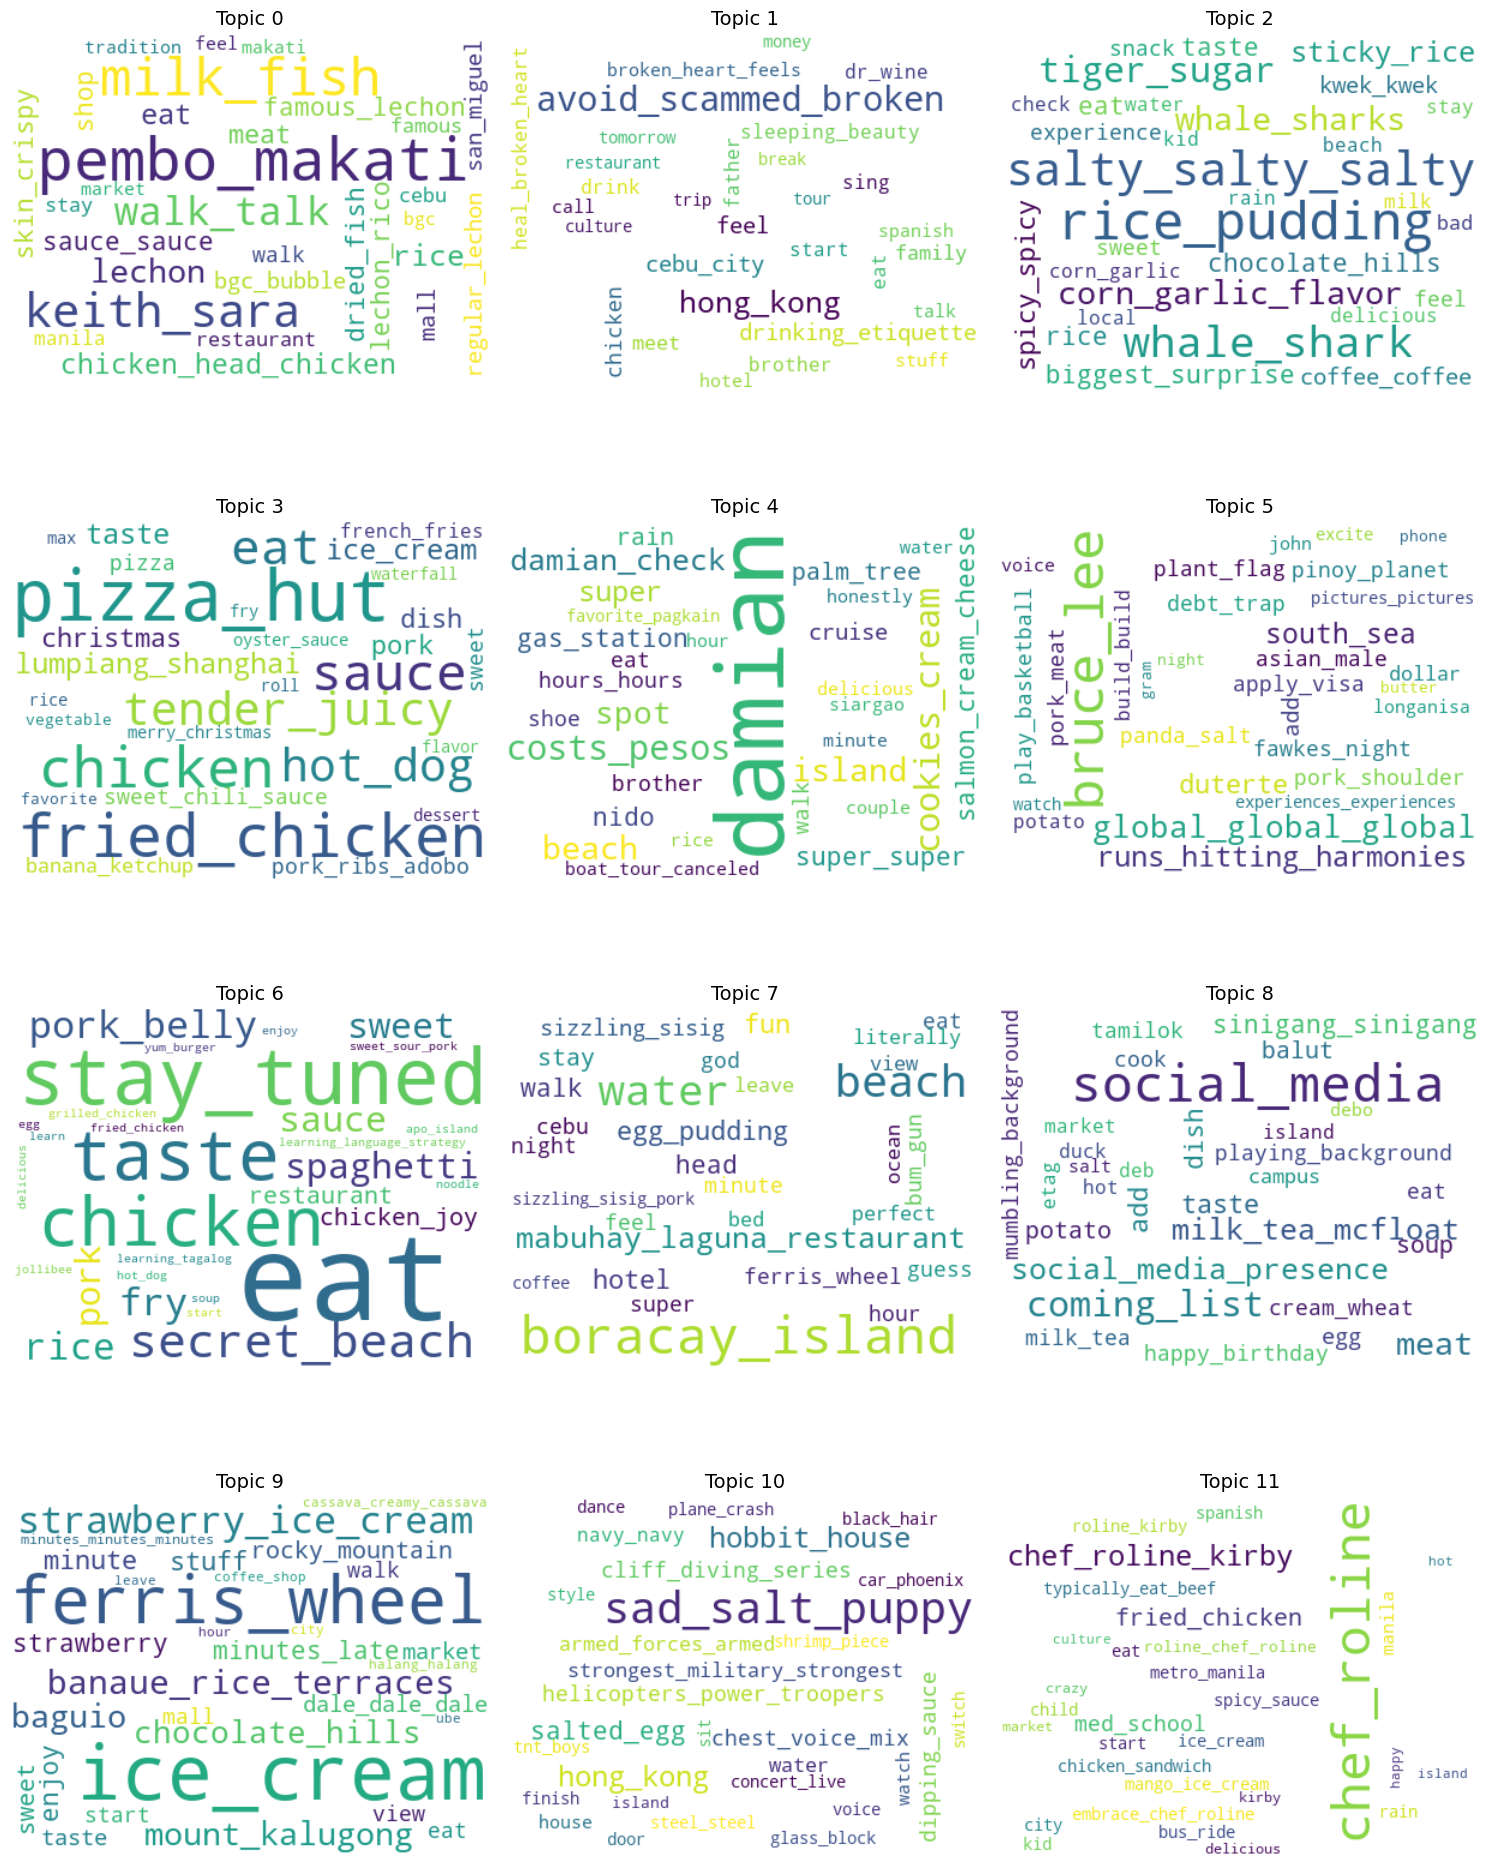

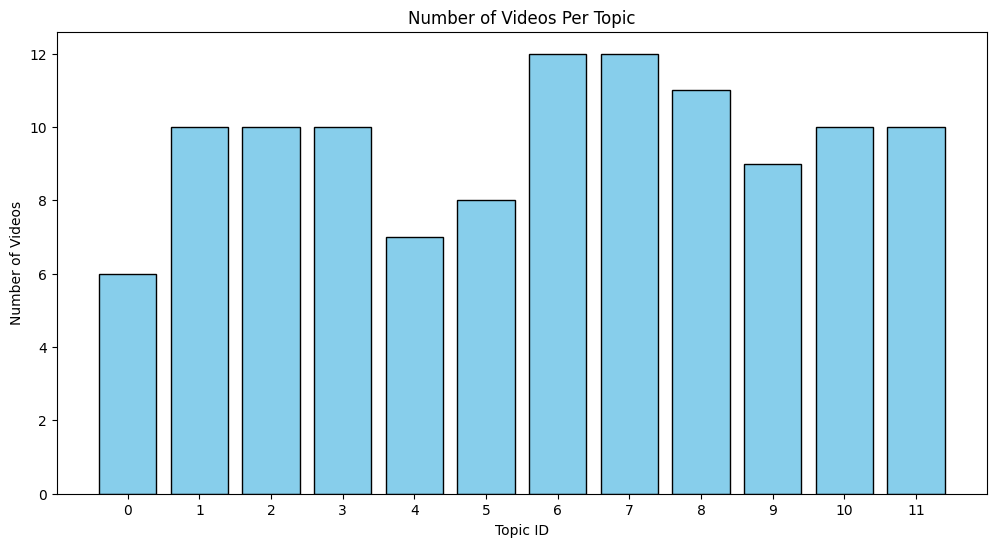

In [8]:
plot_wordclouds(lda_model_12)
plot_topic_distribution(topic_counts)

### 10 Topics

In [9]:
# Train LDA Model
lda_model_10 = LdaModel(corpus, num_topics=10, id2word=dictionary, alpha='auto', eta='symmetric', passes=100)

# Compute Coherence Score
coherence_model = CoherenceModel(model=lda_model_10, corpus=corpus, dictionary=dictionary, coherence='u_mass')
coherence_score = coherence_model.get_coherence()
print(f"Coherence Score: {coherence_score}")

# Print Topics
topics = lda_model_10.print_topics(num_words=20)
for topic_id, topic_words in topics:
    print(f"Topic {topic_id}: {topic_words}")

Coherence Score: -10.072418427533961
Topic 0: 0.032*"rice_pudding" + 0.019*"hong_kong" + 0.008*"sticky_rice" + 0.008*"med_school" + 0.008*"eat" + 0.007*"chicken" + 0.006*"rice" + 0.005*"brother" + 0.005*"kwek_kwek" + 0.005*"coffee_coffee" + 0.004*"hotel" + 0.004*"salmon_cream_cheese" + 0.004*"father" + 0.004*"banana" + 0.004*"sweet" + 0.004*"hot" + 0.004*"south_sea" + 0.004*"family" + 0.004*"duterte" + 0.004*"local"
Topic 1: 0.195*"chef_roline" + 0.025*"chef_roline_kirby" + 0.012*"hobbit_house" + 0.006*"roline_kirby" + 0.006*"embrace_chef_roline" + 0.006*"learning_language_strategy" + 0.006*"cliff_diving_series" + 0.006*"learning_tagalog" + 0.005*"roline_chef_roline" + 0.004*"kirby" + 0.004*"strategy" + 0.004*"bitter_melon" + 0.004*"car_phoenix" + 0.004*"learning_language" + 0.004*"filipina_heart" + 0.004*"kirby_kirby" + 0.003*"island" + 0.003*"language" + 0.003*"eat" + 0.003*"learn"
Topic 2: 0.024*"bruce_lee" + 0.011*"fried_chicken" + 0.009*"beach" + 0.007*"water" + 0.006*"manila" + 0

In [10]:
for idx, doc_bow in enumerate(corpus):
    video_id = video_ids[idx]
    topic_distribution = lda_model_10.get_document_topics(doc_bow, minimum_probability=0)
    dominant_topic = sorted(topic_distribution, key=lambda x: x[1], reverse=True)[0]  # Highest probability
    print(f"Video {video_id}: Dominant Topic {dominant_topic[0]} with probability {dominant_topic[1]:.4f}")


Video --8n6A8Q6M0_$200 Luxury Beach Hotel in The Philippines ðŸ‡µðŸ‡­: Dominant Topic 2 with probability 0.9999
Video 0IMWasj76yU_Philippines Army vs Thailand Army: Dominant Topic 7 with probability 0.9996
Video 1kErCqgIVMk_Tour of The House We Built in The Philippines: Dominant Topic 6 with probability 0.9998
Video 2ftG8JuMzz4_Top 5 Exotic Foods in the Philippines The BRAVE MUST TRY!: Dominant Topic 4 with probability 0.9998
Video 2TmagN6RhkI_VOCAL COACH REACTS - REGINE VELASQUEZ - Araw-Gabi: Dominant Topic 9 with probability 0.9996
Video 3n1nspLgfd4_Balut!!!!! - Manila, Philippines - Now United: Dominant Topic 8 with probability 0.9970
Video 401ZvQ11euA_Did China Buy the Philippines With False Investment Promises: Dominant Topic 0 with probability 0.9998
Video 4OiOwDh5lKE_Chef Kuya Joey Is Flying To The Philippines!  ðŸ‡µðŸ‡­: Dominant Topic 5 with probability 0.8707
Video 6ftiWoCJ4dM_Filipino Food In The Netherlands  Cafe Nordrick!!: Dominant Topic 8 with probability 0.9986
Video 7j

In [11]:
from collections import defaultdict

# Dictionary to store the count of videos per topic
topic_video_count = defaultdict(int)

# Mapping of video ID to its dominant topic
video_topic_mapping_10 = {}

for idx, doc_bow in enumerate(corpus):
    video_id = video_ids[idx]  # Get video ID
    topic_distribution = lda_model_10.get_document_topics(doc_bow, minimum_probability=0)

    # Get the most dominant topic (highest probability)
    dominant_topic = sorted(topic_distribution, key=lambda x: x[1], reverse=True)[0][0]
    
    # Store the mapping
    video_topic_mapping_10[video_id] = dominant_topic
    
    # Increase count for that topic
    topic_video_count[dominant_topic] += 1

# Print number of videos assigned to each topic
print("\nNumber of Videos per Topic:")
for topic, count in sorted(topic_video_count.items()):
    print(f"Topic {topic}: {count} videos")



Number of Videos per Topic:
Topic 0: 10 videos
Topic 1: 8 videos
Topic 2: 9 videos
Topic 3: 11 videos
Topic 4: 13 videos
Topic 5: 16 videos
Topic 6: 11 videos
Topic 7: 9 videos
Topic 8: 10 videos
Topic 9: 3 videos


In [12]:
topic_to_videos = defaultdict(list)

video_topic_mapping_10 = {}

# probability threshold for assigning multiple topics
prob_threshold = 0.2

# Dictionary to store topic words for each video
video_topic_words_LDA1_10 = {}

for idx, doc_bow in enumerate(corpus):
    video_id = video_ids[idx]  # Get video ID
    topic_distribution = lda_model_10.get_document_topics(doc_bow, minimum_probability=0)

    # Get topics where probability is above threshold
    assigned_topics = [topic for topic, prob in topic_distribution if prob >= prob_threshold]
    video_topic_mapping_10[video_id] = assigned_topics  # Store assigned topics per video

    for topic in assigned_topics:
        topic_to_videos[topic].append(video_id)

    # Get the representative words for each assigned topic
    topic_words = []
    for topic in assigned_topics:
        words = [word for word, _ in lda_model_10.show_topic(topic, topn=10)]  # Get top 10 words
        topic_words.append(", ".join(words))  # Convert list to string

    # Store the topic words as a string
    video_topic_words_LDA1_10[video_id] = "; ".join(topic_words)  # Separate topics with `;`

# Count occurrences of each topic
topic_counts = Counter()

for topics in video_topic_mapping_10.values():
    for topic in topics:
        topic_counts[topic] += 1

# Print the number of videos per topic
print("\nNumber of Videos Per Topic:")
for topic, count in sorted(topic_counts.items()):
    print(f"Topic {topic}: {count} videos")

# Print topics assigned per video
print("\nTopics Assigned Per Video:")
for video_id, topics in video_topic_mapping_10.items():
    topic_list = ', '.join(map(str, topics)) if topics else "No dominant topic"
    print(f"Video ID: {video_id} → Topics: {topic_list}")

# Print videos per topic
print("\nTop Words Per Topic:")
num_words = 30  

for topic_id in sorted(topic_to_videos.keys()): 
    top_words = lda_model_10.show_topic(topic_id, num_words)
    words_str = ', '.join([word for word, prob in top_words])
    print(f"Topic {topic_id}: {words_str}")



Number of Videos Per Topic:
Topic 0: 11 videos
Topic 1: 8 videos
Topic 2: 10 videos
Topic 3: 12 videos
Topic 4: 14 videos
Topic 5: 17 videos
Topic 6: 14 videos
Topic 7: 9 videos
Topic 8: 13 videos
Topic 9: 3 videos

Topics Assigned Per Video:
Video ID: --8n6A8Q6M0_$200 Luxury Beach Hotel in The Philippines ðŸ‡µðŸ‡­ → Topics: 2
Video ID: 0IMWasj76yU_Philippines Army vs Thailand Army → Topics: 7
Video ID: 1kErCqgIVMk_Tour of The House We Built in The Philippines → Topics: 6
Video ID: 2ftG8JuMzz4_Top 5 Exotic Foods in the Philippines The BRAVE MUST TRY! → Topics: 4
Video ID: 2TmagN6RhkI_VOCAL COACH REACTS - REGINE VELASQUEZ - Araw-Gabi → Topics: 9
Video ID: 3n1nspLgfd4_Balut!!!!! - Manila, Philippines - Now United → Topics: 8
Video ID: 401ZvQ11euA_Did China Buy the Philippines With False Investment Promises → Topics: 0
Video ID: 4OiOwDh5lKE_Chef Kuya Joey Is Flying To The Philippines!  ðŸ‡µðŸ‡­ → Topics: 5
Video ID: 6ftiWoCJ4dM_Filipino Food In The Netherlands  Cafe Nordrick!! → Topics: 

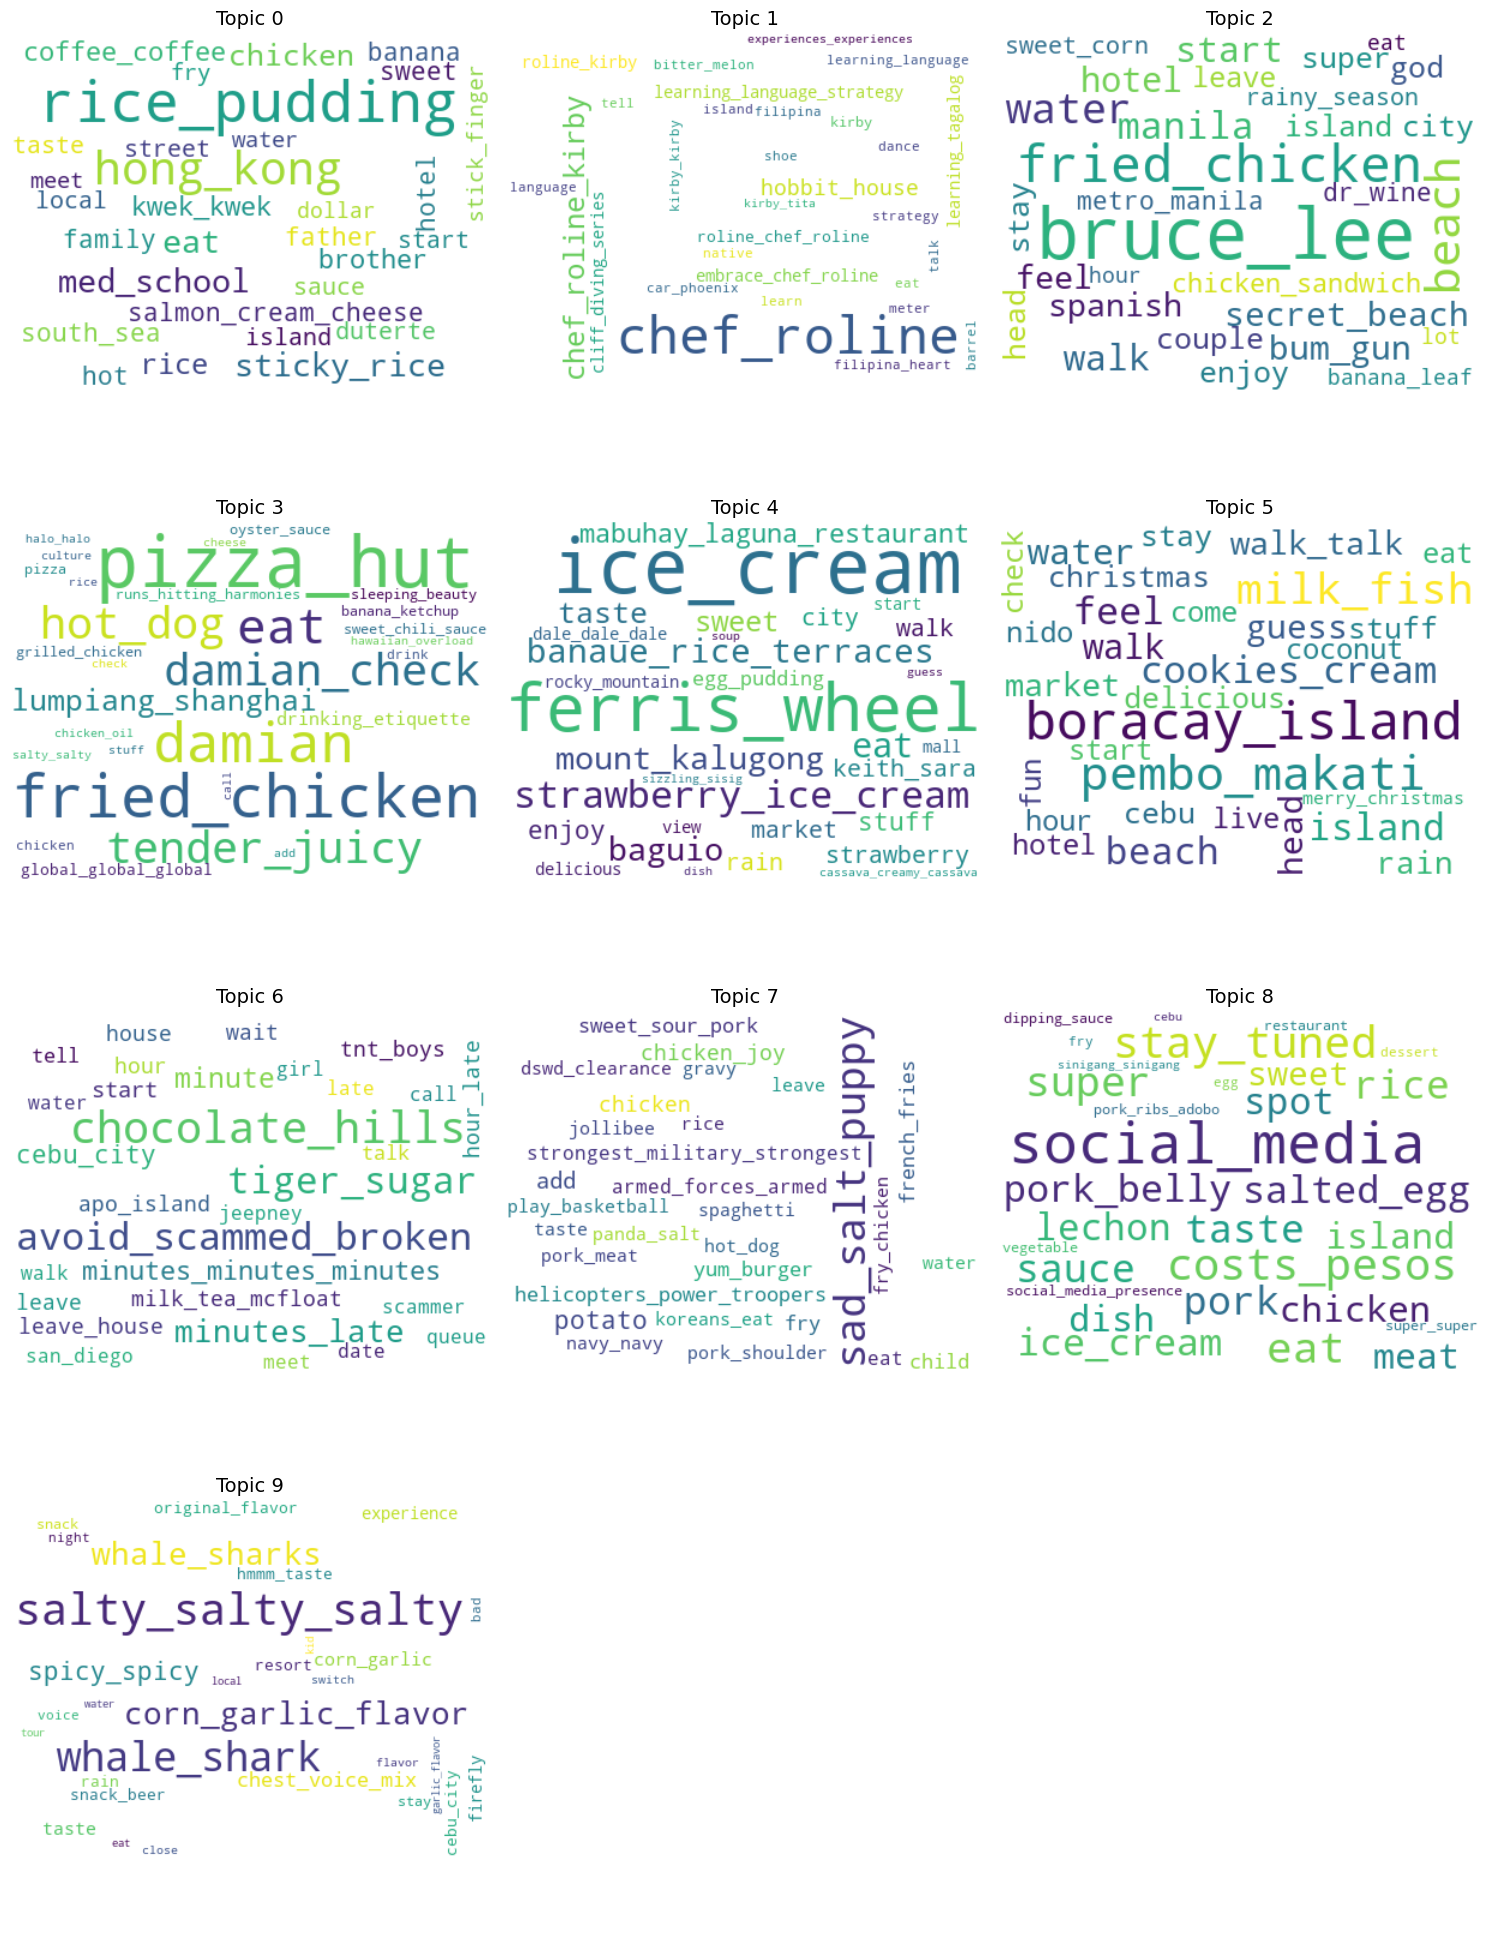

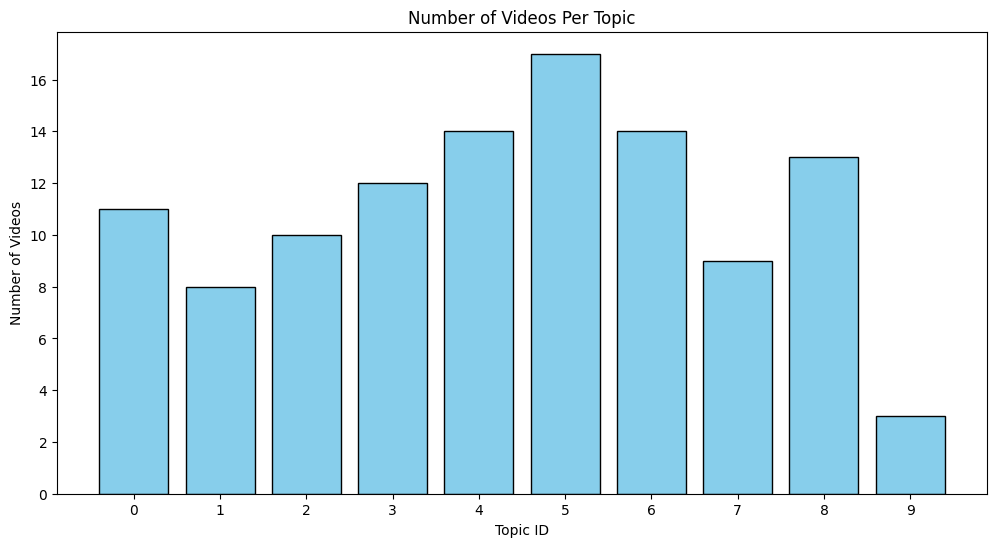

In [13]:
plot_wordclouds(lda_model_10)
plot_topic_distribution(topic_counts)

### 7 Topics

In [14]:
# Train LDA Model
lda_model_7 = LdaModel(corpus, num_topics=7, id2word=dictionary, alpha='auto', eta='symmetric', passes=100)

# Compute Coherence Score
coherence_model = CoherenceModel(model=lda_model_7, corpus=corpus, dictionary=dictionary, coherence='u_mass')
coherence_score = coherence_model.get_coherence()
print(f"Coherence Score: {coherence_score}")

# Print Topics
topics = lda_model_7.print_topics(num_words=20)
for topic_id, topic_words in topics:
    print(f"Topic {topic_id}: {topic_words}")

for idx, doc_bow in enumerate(corpus):
    video_id = video_ids[idx]
    topic_distribution = lda_model_7.get_document_topics(doc_bow, minimum_probability=0)
    dominant_topic = sorted(topic_distribution, key=lambda x: x[1], reverse=True)[0]  # Highest probability
    print(f"Video {video_id}: Dominant Topic {dominant_topic[0]} with probability {dominant_topic[1]:.4f}")


# Mapping of video ID to its dominant topic
video_topic_mapping_7 = {}

for idx, doc_bow in enumerate(corpus):
    video_id = video_ids[idx]  # Get video ID
    topic_distribution = lda_model_7.get_document_topics(doc_bow, minimum_probability=0)

    # Get the most dominant topic (highest probability)
    dominant_topic = sorted(topic_distribution, key=lambda x: x[1], reverse=True)[0][0]
    
    # Store the mapping
    video_topic_mapping_7[video_id] = dominant_topic
    
    # Increase count for that topic
    topic_video_count[dominant_topic] += 1

# Print number of videos assigned to each topic
print("\nNumber of Videos per Topic: (Forced to One Video = One Topic)")
for topic, count in sorted(topic_video_count.items()):
    print(f"Topic {topic}: {count} videos")

Coherence Score: -10.618574211230182
Topic 0: 0.023*"bruce_lee" + 0.015*"whale_shark" + 0.012*"avoid_scammed_broken" + 0.008*"whale_sharks" + 0.007*"damian" + 0.006*"med_school" + 0.005*"chicken" + 0.005*"add" + 0.005*"potato" + 0.005*"sauce" + 0.005*"eat" + 0.005*"taste" + 0.004*"ice_cream" + 0.004*"damian_check" + 0.004*"water" + 0.004*"rice" + 0.004*"dessert" + 0.004*"sweet" + 0.004*"flavor" + 0.003*"local"
Topic 1: 0.011*"social_media" + 0.010*"pembo_makati" + 0.008*"milk_fish" + 0.008*"eat" + 0.007*"ice_cream" + 0.006*"taste" + 0.005*"delicious" + 0.004*"rain" + 0.004*"halang_halang" + 0.004*"walk_talk" + 0.004*"salted_egg" + 0.004*"super" + 0.004*"sauce" + 0.004*"rice" + 0.004*"market" + 0.004*"pork" + 0.004*"chicken" + 0.003*"christmas" + 0.003*"lechon" + 0.003*"feel"
Topic 2: 0.012*"ice_cream" + 0.011*"ferris_wheel" + 0.011*"strawberry_ice_cream" + 0.008*"pizza_hut" + 0.008*"banaue_rice_terraces" + 0.007*"baguio" + 0.007*"mount_kalugong" + 0.007*"tiger_sugar" + 0.006*"fried_chi

In [15]:
# probability threshold for assigning multiple topics
prob_threshold = 0.2

# Dictionary to store topic words for each video
video_topic_words_LDA1_7 = {}

for idx, doc_bow in enumerate(corpus):
    video_id = video_ids[idx]  # Get video ID
    topic_distribution = lda_model_7.get_document_topics(doc_bow, minimum_probability=0)

    # Get topics where probability is above threshold
    assigned_topics = [topic for topic, prob in topic_distribution if prob >= prob_threshold]
    video_topic_mapping_7[video_id] = assigned_topics  # Store assigned topics per video

    for topic in assigned_topics:
        topic_to_videos[topic].append(video_id)

    # Get the representative words for each assigned topic
    topic_words = []
    for topic in assigned_topics:
        words = [word for word, _ in lda_model_7.show_topic(topic, topn=10)]  # Get top 10 words
        topic_words.append(", ".join(words))  # Convert list to string

    # Store the topic words as a string
    video_topic_words_LDA1_7[video_id] = "; ".join(topic_words)  # Separate topics with `;`

# Count occurrences of each topic
topic_counts = Counter()

for topics in video_topic_mapping_7.values():
    for topic in topics:
        topic_counts[topic] += 1

# Print the number of videos per topic
print("\nNumber of Videos Per Topic:")
for topic, count in sorted(topic_counts.items()):
    print(f"Topic {topic}: {count} videos")

# Print topics assigned per video
print("\nTopics Assigned Per Video:")
for video_id, topics in video_topic_mapping_7.items():
    topic_list = ', '.join(map(str, topics)) if topics else "No dominant topic"
    print(f"Video ID: {video_id} → Topics: {topic_list}")

# Print videos per topic
print("\nTop Words Per Topic:")
num_words = 30  
num_topics = lda_model_7.num_topics

for topic_id in sorted(topic_to_videos.keys()):
    if topic_id < num_topics:  # Ensure topic_id is valid
        top_words = lda_model_7.show_topic(topic_id, num_words)
        words_str = ', '.join([word for word, prob in top_words])
        print(f"Topic {topic_id}: {words_str}")
    else:
        print("")


Number of Videos Per Topic:
Topic 0: 15 videos
Topic 1: 19 videos
Topic 2: 13 videos
Topic 3: 21 videos
Topic 4: 10 videos
Topic 5: 10 videos
Topic 6: 26 videos

Topics Assigned Per Video:
Video ID: --8n6A8Q6M0_$200 Luxury Beach Hotel in The Philippines ðŸ‡µðŸ‡­ → Topics: 6
Video ID: 0IMWasj76yU_Philippines Army vs Thailand Army → Topics: 4
Video ID: 1kErCqgIVMk_Tour of The House We Built in The Philippines → Topics: 2
Video ID: 2ftG8JuMzz4_Top 5 Exotic Foods in the Philippines The BRAVE MUST TRY! → Topics: 2
Video ID: 2TmagN6RhkI_VOCAL COACH REACTS - REGINE VELASQUEZ - Araw-Gabi → Topics: 1
Video ID: 3n1nspLgfd4_Balut!!!!! - Manila, Philippines - Now United → Topics: 3, 5, 6
Video ID: 401ZvQ11euA_Did China Buy the Philippines With False Investment Promises → Topics: 5
Video ID: 4OiOwDh5lKE_Chef Kuya Joey Is Flying To The Philippines!  ðŸ‡µðŸ‡­ → Topics: 1, 6
Video ID: 6ftiWoCJ4dM_Filipino Food In The Netherlands  Cafe Nordrick!! → Topics: 4
Video ID: 7jDrzdX2Ucc_Approve ba ako sa ana

## Topics generated per Transcript

In [16]:
# Dictionary to store LDA2 topic words for each video
video_topics = {}
video_topic_words_lda2 = {}
video_segments = {}  # To store segments for each video

# Create a global dictionary for LDA
dictionary = corpora.Dictionary()

# Process each video
for video_id, file_name in transcript_files:
    with open(os.path.join(transcripts_folder_path, file_name), 'r', encoding='utf-8') as file:
        content = file.read().lower()
        
        if len(content.split()) >= 100:  
            # Preprocess text and get segments
            processed_text, segments = preprocess_text(content, video_id)
            
            # Store segments for the video
            video_segments[video_id] = segments
            
            # Create Dictionary and Corpus
            tokens = processed_text.split()
            dictionary.add_documents([tokens])  # Update global dictionary
            corpus = [dictionary.doc2bow(tokens)]
            
            # Train LDA Model
            num_topics = 3  # Limit topics to at most 5 or vocab size
            lda_model_2 = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, alpha='auto', eta='symmetric', passes=100)
            
            # Compute Coherence Score
            coherence_model = CoherenceModel(model=lda_model_2, corpus=corpus, dictionary=dictionary, coherence='u_mass')
            coherence_score = coherence_model.get_coherence()
            
            # Get topic distribution for the video
            topic_distribution = lda_model_2.get_document_topics(corpus[0], minimum_probability=0)
            assigned_topics = {topic: prob for topic, prob in topic_distribution if prob > 0.5}  # Threshold for multiple topics
            
            # Store video topic info
            video_topics[video_id] = {
                "topics": assigned_topics,
                "top_words": {i: lda_model_2.show_topic(i, 20) for i in range(num_topics)},
                "coherence": coherence_score
            }

# Populate video_topic_words_lda2
for video_id, data in video_topics.items():
    topic_words = []
    
    for topic_id, prob in data["topics"].items():
        words = [word for word, _ in data["top_words"][topic_id]]  # Extract top words
        topic_words.append(", ".join(words))  # Convert list to string

    # Store the topic words as a string
    video_topic_words_lda2[video_id] = "; ".join(topic_words)  # Separate topics with `;`

# Print topics per video
for video_id, data in video_topics.items():
    print(f"\nVideo ID: {video_id}")
    print(f"Coherence Score: {data['coherence']:.4f}")
    print("Assigned Topics:")
    for topic_id, prob in data["topics"].items():
        print(f"  Topic {topic_id} ({prob:.2f} probability): {[word for word, _ in data['top_words'][topic_id]]}")
    
    # Display segments for the video
    print("\nSegments:")
    for i, segment in enumerate(video_segments[video_id], 1):
        print(f"Segment {i}: {segment}")


Video ID: --8n6A8Q6M0_$200 Luxury Beach Hotel in The Philippines ðŸ‡µðŸ‡­
Coherence Score: 0.0000
Assigned Topics:
  Topic 0 (1.00 probability): ['beach', 'bum_gun', 'hotel', 'water', 'rainy_season', 'jet', 'god', 'super', 'perfect', 'ski', 'head', 'stay', 'walk', 'hour', 'sand', 'bed', 'tide', 'couple', 'fun', 'margarita']

Segments:
Segment 1: oh my god
it is just the perfect recipe for a good day
want some beer
sure
oh it's big bottle
oh my goodness
three tarzan
good morning from bohol here in the philippines
everybody guys this look
how gorgeous this place is
crystal clear water
it's just honestly such a vibe perfect
temperature to be spending the day by the beach
and that is exactly what we're gonna do
today because i'm staying about 200 meters
up that way at a $200 per night hotel
on there for the next couple of nights
and i arrived in the uh last night
uh it was raining
it was kind of a little bit miserable
so i was like you know what
we'll wait until the weather is good and bo

In [17]:
# # K-Means Segmentation
# def segment_text_kmeans(doc, max_segments=10):
#     sentences = sent_tokenize(doc)
    
#     if len(sentences) <= 1:
#         return [doc]
    
#     # Generate sentence embeddings with normalization
#     sentence_embeddings = embedding_model.encode(sentences, normalize_embeddings=True)

#     # Determine the number of segments (ensure it's valid)
#     num_segments = min(max_segments, len(sentences) // 2) 

#     # Perform K-means clustering with cosine distance
#     kmeans = KMeans(n_clusters=num_segments, random_state=42, n_init=10)
#     clusters = kmeans.fit_predict(sentence_embeddings)

#     # Group sentences by cluster
#     segmented_text = []
#     for cluster_id in range(num_segments):
#         cluster_sentences = [sentence for sentence, cluster in zip(sentences, clusters) if cluster == cluster_id]
#         if cluster_sentences:  # ✅ Avoid empty clusters
#             segmented_text.append(' '.join(cluster_sentences))
    
#     return segmented_text

# transcript_files = []
# for file_name in os.listdir(transcripts_folder_path):
#     if file_name.endswith('.txt'):
#         video_id = file_name.split('_captions')[0]
#         video_ids.append(video_id)
#         transcript_files.append((video_id, file_name)) 

# video_tags = load_video_tags(tags_folder_path, video_ids)

# all_documents = []
# all_segments = []  # To store segments for each document

# for video_id, file_name in transcript_files:
#     with open(os.path.join(transcripts_folder_path, file_name), 'r', encoding='utf-8') as file:
#         content = file.read().lower()
#         if len(content.split()) >= 100: 
#             processed_text, segments = preprocess_text(content, video_id)  # Get both processed text and segments
#             all_documents.append(processed_text)
#             all_segments.append((video_id, segments))  # Store segments with video ID

# # Display segments for each document
# print("\nSegments per Document:")
# for video_id, segments in all_segments:
#     print(f"\nVideo ID: {video_id}")
#     for i, segment in enumerate(segments, 1):
#         print(f"Segment {i}: {segment}")

In [18]:
# # Create Dictionary and Corpus for LDA
# dictionary = corpora.Dictionary([doc.split() for doc in all_documents])
# corpus = [dictionary.doc2bow(doc.split()) for doc in all_documents]

# # Train LDA model
# lda_model = LdaModel(corpus, num_topics=10, id2word=dictionary, alpha='auto', eta='symmetric', passes=100)

# # Compute coherence score
# coherence_model = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
# coherence_score = coherence_model.get_coherence()

# print(f"Coherence Score: {coherence_score}")

# for idx, doc_bow in enumerate(corpus):
#     video_id = video_ids[idx]  
#     topic_distribution = lda_model.get_document_topics(doc_bow, minimum_probability=0)
#     print(f"Video {video_id}: {topic_distribution}")

# topics = lda_model.print_topics(num_words=20) 
# for topic_id, topic_words in topics:
#     print(f"Topic {topic_id}: {topic_words}")


In [19]:
# for idx, doc_bow in enumerate(corpus):
#     video_id = video_ids[idx]
#     topic_distribution = lda_model.get_document_topics(doc_bow, minimum_probability=0)
#     dominant_topic = sorted(topic_distribution, key=lambda x: x[1], reverse=True)[0]  # Highest probability
#     print(f"Video {video_id}: Dominant Topic {dominant_topic[0]} with probability {dominant_topic[1]:.4f}")


In [20]:
# from collections import defaultdict

# # Dictionary to store the count of videos per topic
# topic_video_count = defaultdict(int)

# # Mapping of video ID to its dominant topic
# video_topic_mapping = {}

# for idx, doc_bow in enumerate(corpus):
#     video_id = video_ids[idx]  # Get video ID
#     topic_distribution = lda_model.get_document_topics(doc_bow, minimum_probability=0)

#     # Get the most dominant topic (highest probability)
#     dominant_topic = sorted(topic_distribution, key=lambda x: x[1], reverse=True)[0][0]
    
#     # Store the mapping
#     video_topic_mapping[video_id] = dominant_topic
    
#     # Increase count for that topic
#     topic_video_count[dominant_topic] += 1

# # Print number of videos assigned to each topic
# print("\nNumber of Videos per Topic:")
# for topic, count in sorted(topic_video_count.items()):
#     print(f"Topic {topic}: {count} videos")


In [21]:
# topic_to_videos = defaultdict(list)

# video_topic_mapping = {}

# # probability threshold for assigning multiple topics
# prob_threshold = 0.2

# # Dictionary to store topic words for each video
# video_topic_words_LDA1 = {}

# for idx, doc_bow in enumerate(corpus):
#     video_id = video_ids[idx]  # Get video ID
#     topic_distribution = lda_model.get_document_topics(doc_bow, minimum_probability=0)

#     # Get topics where probability is above threshold
#     assigned_topics = [topic for topic, prob in topic_distribution if prob >= prob_threshold]
#     video_topic_mapping[video_id] = assigned_topics  # Store assigned topics per video

#     for topic in assigned_topics:
#         topic_to_videos[topic].append(video_id)

#     # Get the representative words for each assigned topic
#     topic_words = []
#     for topic in assigned_topics:
#         words = [word for word, _ in lda_model.show_topic(topic, topn=20)]  # Get top 10 words
#         topic_words.append(", ".join(words))  # Convert list to string

#     # Store the topic words as a string
#     video_topic_words_LDA1[video_id] = "; ".join(topic_words)  # Separate topics with `;`

# # Count occurrences of each topic
# topic_counts = Counter()

# for topics in video_topic_mapping.values():
#     for topic in topics:
#         topic_counts[topic] += 1

# # Print the number of videos per topic
# print("\nNumber of Videos Per Topic:")
# for topic, count in sorted(topic_counts.items()):
#     print(f"Topic {topic}: {count} videos")

# # Print topics assigned per video
# print("\nTopics Assigned Per Video:")
# for video_id, topics in video_topic_mapping.items():
#     topic_list = ', '.join(map(str, topics)) if topics else "No dominant topic"
#     print(f"Video ID: {video_id} → Topics: {topic_list}")

# # Print videos per topic
# print("\nTop Words Per Topic:")
# num_words = 30  

# for topic_id in sorted(topic_to_videos.keys()): 
#     top_words = lda_model.show_topic(topic_id, num_words)
#     words_str = ', '.join([word for word, prob in top_words])
#     print(f"Topic {topic_id}: {words_str}")


In [22]:
# transcript_files = []
# for file_name in os.listdir(transcripts_folder_path):
#     if file_name.endswith('.txt'):
#         video_id = file_name.split('_captions')[0]
#         video_ids.append(video_id)
#         transcript_files.append((video_id, file_name)) 

# # Dictionary to store LDA2 topic words for each video
# video_topics = {}
# video_topic_words_lda2 = {}
# video_segments = {}  # To store segments for each video

# # Create a global dictionary for LDA
# dictionary = corpora.Dictionary()

# # Process each video
# for video_id, file_name in transcript_files:
#     with open(os.path.join(transcripts_folder_path, file_name), 'r', encoding='utf-8') as file:
#         content = file.read().lower()
        
#         if len(content.split()) >= 100:  
#             # Preprocess text and get segments
#             processed_text, segments = preprocess_text(content, video_id)
            
#             # Store segments for the video
#             video_segments[video_id] = segments
            
#             # Create Dictionary and Corpus
#             tokens = processed_text.split()
#             dictionary.add_documents([tokens])  # Update global dictionary
#             corpus = [dictionary.doc2bow(tokens)]
            
#             # Train LDA Model
#             num_topics = 3  # Limit topics to at most 5 or vocab size
#             lda_model_2 = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, alpha='auto', eta='symmetric', passes=100)
            
#             # Compute Coherence Score
#             coherence_model = CoherenceModel(model=lda_model_2, corpus=corpus, dictionary=dictionary, coherence='u_mass')
#             coherence_score = coherence_model.get_coherence()
            
#             # Get topic distribution for the video
#             topic_distribution = lda_model_2.get_document_topics(corpus[0], minimum_probability=0)
#             assigned_topics = {topic: prob for topic, prob in topic_distribution if prob > 0.5}  # Threshold for multiple topics
            
#             # Store video topic info
#             video_topics[video_id] = {
#                 "topics": assigned_topics,
#                 "top_words": {i: lda_model_2.show_topic(i, 20) for i in range(num_topics)},
#                 "coherence": coherence_score
#             }

# # Populate video_topic_words_lda2
# for video_id, data in video_topics.items():
#     topic_words = []
    
#     for topic_id, prob in data["topics"].items():
#         words = [word for word, _ in data["top_words"][topic_id]]  # Extract top words
#         topic_words.append(", ".join(words))  # Convert list to string

#     # Store the topic words as a string
#     video_topic_words_lda2[video_id] = "; ".join(topic_words)  # Separate topics with `;`

# # Print topics per video
# for video_id, data in video_topics.items():
#     print(f"\nVideo ID: {video_id}")
#     print(f"Coherence Score: {data['coherence']:.4f}")
#     print("Assigned Topics:")
#     for topic_id, prob in data["topics"].items():
#         print(f"  Topic {topic_id} ({prob:.2f} probability): {[word for word, _ in data['top_words'][topic_id]]}")
    
#     # Display segments for the video
#     print("\nSegments:")
#     for i, segment in enumerate(video_segments[video_id], 1):
#         print(f"Segment {i}: {segment}")

In [23]:
# def preprocess_text(doc, video_id, tag_weight=2, ngram_weight_factor=2):
#     # Clean and tokenize text
#     doc = doc.lower().translate(str.maketrans('', '', string.punctuation))
#     tokens = word_tokenize(doc)

#     # Remove stopwords
#     tokens = [word for word in tokens if word not in stop_words and word.isalpha() and is_latin_script(word)]

#     # Detect meaningful bigram and trigram collocations
#     bigrams, trigrams = detect_collocations(tokens)

#     # Generate n-grams (both bigrams and trigrams)
#     bigram_tokens = ['_'.join(gram) for gram in ngrams(tokens, 2)]
#     trigram_tokens = ['_'.join(gram) for gram in ngrams(tokens, 3)]

#     # Count n-gram frequency
#     bigram_frequencies = Counter(bigram_tokens)
#     trigram_frequencies = Counter(trigram_tokens)

#     # Merge n-grams into single tokens
#     merged_tokens = []
#     i = 0
#     while i < len(tokens) - 2:  # Check for trigrams first
#         trigram = f"{tokens[i]}_{tokens[i+1]}_{tokens[i+2]}"
#         bigram = f"{tokens[i]}_{tokens[i+1]}"

#         if trigram in trigrams:
#             merged_tokens.append(trigram)
#             i += 3  # Skip next two words since it's part of the trigram
#         elif bigram in bigrams:
#             merged_tokens.append(bigram)
#             i += 2  # Skip next word since it's part of the bigram
#         else:
#             merged_tokens.append(tokens[i])
#             i += 1

#     # Append any remaining words
#     while i < len(tokens):
#         merged_tokens.append(tokens[i])
#         i += 1

#     # POS tagging
#     tokens_with_pos = pos_tag(merged_tokens)

#     # Apply lemmatization
#     lemmatized_tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in tokens_with_pos]

#     # Assign weight based on n-gram occurrence
#     weighted_tokens = []
#     for token in lemmatized_tokens:
#         if token in trigram_frequencies:
#             token_weight = 1 + trigram_frequencies[token] * ngram_weight_factor  
#         elif token in bigram_frequencies:
#             token_weight = 1 + bigram_frequencies[token] * (ngram_weight_factor - 1)  
#         else:
#             token_weight = 1
#         weighted_tokens.extend([token] * int(token_weight))

#     # Include video tags
#     if video_id in video_tags:
#         tags = video_tags[video_id]
#         for tag in tags:
#             if tag.isalpha():
#                 weighted_tokens.extend([tag] * int(tag_weight))

#     return ' '.join(weighted_tokens)


In [24]:
# all_documents = []
# preprocessed_text = []

# for video_id, file_name in transcript_files:
#     with open(os.path.join(transcripts_folder_path, file_name), 'r', encoding='utf-8') as file:
#         content = file.read().lower()
#         if len(content.split()) >= 100: 
#             processed_text = preprocess_text(content, video_id)  # Get both processed text and segments
#             preprocessed_text.append((video_id, processed_text))
#             all_documents.append(processed_text)

# dictionary = corpora.Dictionary([doc.split() for doc in all_documents])
# corpus = [dictionary.doc2bow(doc.split()) for doc in all_documents]

# # Train LDA Model
# lda_model = LdaModel(corpus, num_topics=10, id2word=dictionary, alpha='auto', eta='symmetric', passes=100)

# # Compute Coherence Score
# coherence_model = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
# coherence_score = coherence_model.get_coherence()
# print(f"Coherence Score: {coherence_score}")

# # Print Topics
# topics = lda_model.print_topics(num_words=20)
# for topic_id, topic_words in topics:
#     print(f"Topic {topic_id}: {topic_words}")

# from collections import defaultdict

# # Dictionary to store the count of videos per topic
# topic_video_count = defaultdict(int)

# # Mapping of video ID to its dominant topic
# video_topic_mapping = {}

# for idx, doc_bow in enumerate(corpus):
#     video_id = video_ids[idx]  # Get video ID
#     topic_distribution = lda_model.get_document_topics(doc_bow, minimum_probability=0)

#     # Get the most dominant topic (highest probability)
#     dominant_topic = sorted(topic_distribution, key=lambda x: x[1], reverse=True)[0][0]
    
#     # Store the mapping
#     video_topic_mapping[video_id] = dominant_topic
    
#     # Increase count for that topic
#     topic_video_count[dominant_topic] += 1

# # Print number of videos assigned to each topic
# print("\nNumber of Videos per Topic:")
# for topic, count in sorted(topic_video_count.items()):
#     print(f"Topic {topic}: {count} videos")


# topic_to_videos = defaultdict(list)

# video_topic_mapping = {}

# # probability threshold for assigning multiple topics
# prob_threshold = 0.2

# # Dictionary to store topic words for each video
# video_topic_words_LDA3 = {}

# for idx, doc_bow in enumerate(corpus):
#     video_id = video_ids[idx]  # Get video ID
#     topic_distribution = lda_model.get_document_topics(doc_bow, minimum_probability=0)

#     # Get topics where probability is above threshold
#     assigned_topics = [topic for topic, prob in topic_distribution if prob >= prob_threshold]
#     video_topic_mapping[video_id] = assigned_topics  # Store assigned topics per video

#     for topic in assigned_topics:
#         topic_to_videos[topic].append(video_id)

#     # Get the representative words for each assigned topic
#     topic_words = []
#     for topic in assigned_topics:
#         words = [word for word, _ in lda_model.show_topic(topic, topn=10)]  # Get top 10 words
#         topic_words.append(", ".join(words))  # Convert list to string

#     # Store the topic words as a string
#     video_topic_words_LDA3[video_id] = "; ".join(topic_words)  # Separate topics with `;`

# # Count occurrences of each topic
# topic_counts = Counter()

# for topics in video_topic_mapping.values():
#     for topic in topics:
#         topic_counts[topic] += 1

# # Print the number of videos per topic
# print("\nNumber of Videos Per Topic:")
# for topic, count in sorted(topic_counts.items()):
#     print(f"Topic {topic}: {count} videos")

# # Print topics assigned per video
# print("\nTopics Assigned Per Video:")
# for video_id, topics in video_topic_mapping.items():
#     topic_list = ', '.join(map(str, topics)) if topics else "No dominant topic"
#     print(f"Video ID: {video_id} → Topics: {topic_list}")

# # Print videos per topic
# print("\nTop Words Per Topic:")
# num_words = 30  

# for topic_id in sorted(topic_to_videos.keys()): 
#     top_words = lda_model.show_topic(topic_id, num_words)
#     words_str = ', '.join([word for word, prob in top_words])
#     print(f"Topic {topic_id}: {words_str}")


In [25]:
# plot_wordclouds(lda_model)
# plot_topic_distribution(topic_counts)

In [26]:
# video_ids = []
# transcript_files = []

# for file_name in os.listdir(transcripts_folder_path):
#     if file_name.endswith('.txt'):
#         video_id = file_name.split('_captions')[0]
#         video_ids.append(video_id)
#         transcript_files.append((video_id, file_name)) 

# video_topics = {}

# for video_id, file_name in transcript_files:
#     with open(os.path.join(transcripts_folder_path, file_name), 'r', encoding='utf-8') as file:
#         content = file.read().lower()
        
#         if len(content.split()) >= 100:  
#             processed_text = preprocess_text(content, video_id)
            
#             # Create Dictionary and Corpus
#             tokens = processed_text.split()
#             corpus = [dictionary.doc2bow(tokens)]
            
#             # Train LDA Model
#             num_topics = 3 
#             lda_model_2 = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, alpha='auto', eta='symmetric', passes=100)
            
#             # Compute Coherence Score
#             coherence_model = CoherenceModel(model=lda_model_2, corpus=corpus, dictionary=dictionary, coherence='u_mass')
#             coherence_score = coherence_model.get_coherence()
            
#             # Get topic distribution for the video (with all topics)
#             topic_distribution = lda_model_2.get_document_topics(corpus[0], minimum_probability=0)
            
#             # Store video topic info
#             video_topics[video_id] = {
#                 "topics": {topic: prob for topic, prob in topic_distribution},  # Store all topics
#                 "top_words": {i: lda_model_2.show_topic(i, 20) for i in range(num_topics)},
#                 "coherence": coherence_score
#             }

# video_topic_words_lda2 = {}

# for video_id, data in video_topics.items():
#     topic_details = []
    
#     for topic_id, prob in sorted(data["topics"].items(), key=lambda x: -x[1]): 
#         words = [word for word, _ in data["top_words"][topic_id]] 
#         topic_details.append(f"Topic {topic_id} ({prob:.2f}): " + ", ".join(words)) 

#     # Store the topic words
#     video_topic_words_lda2[video_id] = " | ".join(topic_details)  

# for video_id, data in video_topics.items():
#     print(f"\nVideo ID: {video_id}")
#     print(f"Coherence Score: {data['coherence']:.4f}")
#     print("Assigned Topics:")
    
#     for topic_id, prob in sorted(data["topics"].items(), key=lambda x: -x[1]):  # Sort topics by probability
#         print(f"  Topic {topic_id} ({prob:.2f} probability): {[word for word, _ in data['top_words'][topic_id]]}")

# print("\nFormatted Topics Per Video:")
# for video_id, topic_string in video_topic_words_lda2.items():
#     print(f"{video_id}: {topic_string}")

In [27]:
for doc_id, bow in enumerate(corpus):
    print(f"Document {doc_id}:")
    for word_id, freq in bow:
        print(f" - {dictionary[word_id]}: {freq}")


Document 0:
 - bohol: 3
 - brown: 1
 - cebu: 2
 - day: 2
 - die: 1
 - dry: 1
 - formation: 1
 - grow: 1
 - hide: 1
 - hill: 2
 - hole: 2
 - hour: 1
 - island: 4
 - layer: 1
 - leave: 1
 - live: 1
 - mess: 1
 - motorbike: 1
 - nearby: 1
 - pay: 1
 - risk: 1
 - rock: 1
 - safe: 1
 - stay: 1
 - tourist: 1
 - water: 1
 - weather: 1
 - animal: 1
 - call: 1
 - collect: 1
 - piece: 1
 - process: 1
 - tear: 2
 - time: 1
 - ancient: 1
 - form: 1
 - legend: 1
 - popular: 1
 - surface: 1
 - pull: 1
 - hold: 1
 - international: 1
 - leader: 1
 - name: 1
 - city: 3
 - girl: 1
 - locate: 1
 - assume: 1
 - center: 1
 - peace: 1
 - port: 1
 - driver: 1
 - tired: 1
 - green: 1
 - personal: 1
 - fight: 1
 - bud: 1
 - season: 2
 - ferry: 2
 - ticket: 1
 - giant: 2
 - battle: 1
 - luck: 1
 - rainy: 1
 - stone: 1
 - police: 1
 - rainfall: 1
 - villa: 1
 - religion: 1
 - chocolate_hills: 56
 - primate: 1
 - tarsier: 3
 - theory: 2
 - bedrock: 1
 - bribe: 1
 - chokolate: 1
 - chosen: 1
 - cried: 2
 - dissolu

In [29]:
import pandas as pd
import re

def extract_video_id(url):
    """Extracts the 11-character YouTube video ID from a URL."""
    match = re.search(r"(?:v=|\/(?:embed|shorts|v)\/|youtu\.be\/)([0-9A-Za-z_-]{11})", str(url))
    return match.group(1) if match else None

def match_topics(video_id, topic_dict):
    """Matches video ID with topic dictionary keys."""
    if video_id:
        for key in topic_dict.keys():
            if key.startswith(video_id):  # Video ID matches the key prefix
                return topic_dict[key]
    return None

# Load CSV
csv_file = "updated_topics_per_video.csv"
topics_per_video_df = pd.read_csv(csv_file)

# Extract Video ID from the "Link" column
topics_per_video_df["Video_ID"] = topics_per_video_df["Link"].apply(extract_video_id)

# Update LDA1 and LDA2 Topics columns
topics_per_video_df["LDA1 Topics"] = topics_per_video_df["Video_ID"].apply(lambda vid: match_topics(vid, video_topic_words_LDA1_12))
topics_per_video_df["LDA2 Topics"] = topics_per_video_df["Video_ID"].apply(lambda vid: match_topics(vid, video_topic_words_lda2))

# Save the updated CSV
topics_per_video_df.to_csv("topics_per_video.csv", index=False)

print("CSV successfully updated!")


CSV successfully updated!
